<a href="https://colab.research.google.com/github/Samreenhabib/Urdu-OCR/blob/main/making_processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from transformers import AutoFeatureExtractor, AutoTokenizer
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
image_processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-384")
decoder_tokenizer = AutoTokenizer.from_pretrained("urduhack/roberta-urdu-small")

#processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=decoder_tokenizer)
processor = TrOCRProcessor(image_processor=image_processor, tokenizer=decoder_tokenizer)

In [25]:
# processor.save_pretrained('../test/test_processor')
processor.save_pretrained('./preprocessor')

In [26]:
import pandas as pd
import cv2
df = pd.read_excel("sen_dataset.xlsx", header=None)
df.rename(columns={0: "filename", 1: "text"}, inplace=True)
df.head()

,filename,text
0,0.png,فہرست اداریہ ڈاکٹر ثروت رضوی ۴ اقبال کی شاعران...
1,1.png,جمیل یوسف ۵ ———— پروین شاکر کی یاد میں شاہدہ
2,2.png,حسن ۱۲ شاعری میں تانیثیت کے منظرنامے پر دستخط صدف
3,3.png,مرزا ۱۹ پروین شاکر رضیہ سبحان ۳۷ عکسِ خوشبو ہوں—
4,4.png,پروین شاکر ڈاکٹر نزہت عباسی ۴۱ پروین شاکر کی ش...


In [27]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3)

# train_df.dropna()
# test_df.dropna()

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [28]:
test_df.head()

,filename,text
0,1948.png,اور مشورے جو ترقی پسند ادیبوں اورتحریک کے لیے ...
1,5143.png,سے مالامال ہے۔ یہاں مختلف نسلوں اور رنگوں کے لوگ
2,228.png,طرح اور شعرا بھی اس کیفیت سے گزرے ہوں گے۔
3,2002.png,ڈرامے میں شریک تھے۔ اسوقت کسی کے سامنے سیاست یا
4,576.png,ہیں۔ اس کا اندازہ ان کی وفات سے قبل کہے


In [29]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['filename'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length",max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [30]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("./preprocessor/")

train_dataset = IAMDataset(root_dir= "C:/Working_Directory/NCL/Urdu_OCR/FYP/NMT - FYP/images/",
                           df = train_df,
                           processor=processor)

eval_dataset = IAMDataset(root_dir= "C:/Working_Directory/NCL/Urdu_OCR/FYP/NMT - FYP/images/",
                           df = test_df,
                           processor = processor)

C:\Users\danis\anaconda3\envs\easyocr-env\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [31]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 4550
Number of validation examples: 1951


In [32]:
train_dataset[6]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': tensor([    0,   336,   584,  5782, 36689,   550,   418

In [36]:
encoding = train_dataset[5]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


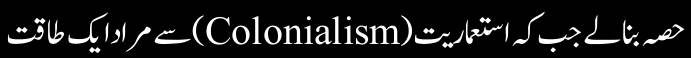

In [37]:
image = Image.open(train_dataset.root_dir + train_df['filename'][5]).convert("RGB")
image

In [38]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

حصہ بنا لے جب کہ استعماریت(Colonialism) سے مراد ایک طاقت


In [39]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-384", 
                                                                  "urduhack/roberta-urdu-small")

# set decoder config to causal lm
model.config.decoder.is_decoder = True
model.config.decoder.add_cross_attention = True

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at urduhack/roberta-ur

using steps 

In [ ]:
# from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# training_args = Seq2SeqTrainingArguments(
#     predict_with_generate=True,
#     evaluation_strategy="steps",
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     fp16=False, 
#     output_dir="./",
#     logging_steps=50,
#     save_steps=20,
#     eval_steps=20,
#     num_train_epochs=40,  
# )

evaluating using epoch

In [41]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
   evaluation_strategy = "epoch",
   learning_rate= 0.002,
   per_device_train_batch_size = 32,
   per_device_eval_batch_size = 8,
   weight_decay = 0.01,
   save_total_limit = 2,
   num_train_epochs = 40,
   output_dir = "./train/",
   predict_with_generate=True,  
)

In [45]:
# from datasets import load_metric
# cer_metric = load_metric("cer")

In [46]:
import evaluate
cer_metric = evaluate.load('cer')

In [47]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [48]:
# import os
# from openpyxl import load_workbook

# def compare_images_with_excel(file_path, folder_path, column_name):
#     # Load the Excel file
#     workbook = load_workbook(file_path)
#     sheet = workbook.active
    
#     # Get the column index based on the column name
#     column_index = None
#     for cell in sheet[1]:
#         if cell.value == column_name:
#             column_index = cell.column_letter
#             break
    
#     # Check if the column was found
#     if column_index is None:
#         print(f"Column '{column_name}' not found in the Excel file.")
#         return
    
#     # Iterate over the values in the specified column
#     for cell in sheet[column_index][1:]:
#         image_filename = cell.value
        
#         # Construct the full image path
#         image_path = os.path.join(folder_path, image_filename)
        
#         # Check if the image file exists
#         if os.path.isfile(image_path):
#             print(f"Image '{image_filename}' found in the folder.")
#             folder.append(image_filename)
#         else:
#             print(f"Image '{image_filename}' not found in the folder.")
    
#     # Close the workbook
#     workbook.close()

# # Example usage
# excel_file_path = "sen_dataset.xlsx"
# image_folder_path = "C:/Working_Directory/NCL/Urdu_OCR/FYP/NMT - FYP/images"
# column_name = "filename"
# folder = []

# compare_images_with_excel(excel_file_path, image_folder_path, column_name)
# len(folder)

Column 'filename' not found in the Excel file.


0

In [ ]:
# import os

# def print_files_in_folder(folder_path):
#     # Get a list of all files in the folder
#     files = os.listdir(folder_path)
    
#     # Iterate over the files and print their names
#     for file_name in files:
#         # Construct the full file path
#         file_path = os.path.join(folder_path, file_name)
        
#         # Check if the file is a regular file
#         if os.path.isfile(file_path):
#             print(file_name)
#             folder.append(file_name)

# # Example usage
# folder_path = "C:/Working_Directory/NCL/Urdu_OCR/FYP/NMT - FYP/images"
# folder = []
# print_files_in_folder(folder_path)
# len(folder)

In [49]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
                        model = model,
                        tokenizer = processor.feature_extractor,
                        args = training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = eval_dataset,
                        data_collator = default_data_collator
                        )
trainer.train()

C:\Users\danis\anaconda3\envs\easyocr-env\lib\site-packages\transformers\models\trocr\processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
C:\Users\danis\anaconda3\envs\easyocr-env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4550
  Num Epochs = 40
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5720
  Number of trainable parameters = 241079584


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.save_model('./trainings/models')

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("./trainings/models")

In [ ]:
image = Image.open('/content/6.png').convert("RGB")

In [ ]:
pixel_values = processor.feature_extractor(image, return_tensors="pt").pixel_values 
print(pixel_values.shape)

In [ ]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

In [ ]:
test = Image.open('/content/8.png').convert("RGB")
testvalues = processor.feature_extractor(test, return_tensors="pt").pixel_values 
print(testvalues.shape)

In [ ]:
testids = model.generate(testvalues)
testtext = processor.batch_decode(testids, skip_special_tokens=True)[0]
print(testtext)